In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import xgboost as xgb
import seaborn as sns 
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from scipy import stats
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
import imblearn
import itertools
from sklearn.metrics import f1_score, make_scorer

# Utilities

In [3]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1 - f1_score(y_true, np.where(y_pred > 0.5, 1, 0), zero_division=1)
    return 'f1_err', err

# Adds mean,std,var to each attribute with a rolling window of a given size
def add_lookback(dataset, exclude ,seconds=1, jmp_size=1):
    cols = list(set(dataset.columns) - set(exclude)) 
    if seconds == 0:
        return dataset
    window = seconds*1000
    jmp_size = jmp_size*1000
    min_time = dataset['time'].min()
    max_time = dataset['time'].max()
    new_cols = [x + f'_mean' for x in cols] + [x + f'_std' for x in cols] + [x + f'_var' for x in cols]
    data = pd.DataFrame(columns=list(dataset.columns) + new_cols)
    data[list(dataset.columns)] = dataset[list(dataset.columns)]
    start = min_time
    while start < max_time:
        sub_df = dataset[cols][(dataset['time']>=start)&(dataset['time']<start+window)]
        aggs = sub_df.agg(['mean','std','var']).reset_index()
        aggs = aggs.fillna(aggs.mean())
        inds = data.loc[(data['time']>=start)&(data['time']<start+window)].index
        for index,row in aggs.iterrows():
            for col in cols:
                data.loc[inds, col+'_'+row['index']] = row[col]
        start += window
        
    return data.fillna(data.mean())
        

    
# Removes 2% and 98% outliers from the data
def remove_outliers(df, col_names):
    index = pd.Index([])
    for col_name in col_names:
        q_low = df[col_name].quantile(0.02)
        q_hi  = df[col_name].quantile(0.98)
        index = index.append(df[(df[col_name] >= q_hi) | (df[col_name] <= q_low)].index)
    return df[~df.index.isin(index)]


def plot_training_chart(results, metrics, train=False):
    epochs = len(results['validation_0'][metrics[0]])
    x_axis = range(0, epochs)
    if train:
        for metric in metrics:
            fig, ax = plt.subplots()
            ax.plot(x_axis, results['validation_0'][metric], label='Train')
            ax.plot(x_axis, results['validation_1'][metric], label='Test')
            ax.legend()
            plt.ylabel(metric)
            plt.title(f'XGBoost {metric}')
            plt.show()
    else:
        for metric in metrics:
            fig, ax = plt.subplots()
            ax.plot(x_axis, results['validation_0'][metric], label='Test')
            ax.legend()
            plt.ylabel(metric)
            plt.title(f'XGBoost {metric}')
            plt.show()
            
            
def draw_confusion_matrix(cf_matrix):
  
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])
    ax = plt.subplot()
    sns.heatmap(df_cm, annot=True, fmt = ".1f", ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    TN = cf_matrix[0][0]
    FP = cf_matrix[0][1]
    TP = cf_matrix[1][1]
    FN = cf_matrix[1][0]
    print(f'True positive samples: {TP} (these are the FOG samples we classified FOG)')
    print(f'False positive samples: {FP} (these are normal samples we classified as FOG)')
    print(f'True negative samples: {TN} (These are the normal samples we classified as normal)')
    print(f'False negative samples: {FN} (Thses are the FOG samples we classified as normal)')
    
def print_scores(y_test, y_pred):
    print(f'Total accuracy is {accuracy_score(y_test, y_pred)}')
    print(f'Percision score (tp / (tp + fp)) is {precision_score(y_test, y_pred, zero_division=1)}')
    print(f'Recall score (tp / (tp + fn)) is {recall_score(y_test, y_pred, zero_division=1)}')
    print(f'F1 score (2 * (precision * recall) / (precision + recall)) is {f1_score(y_test, y_pred, zero_division=1)}')
    
# Uses cross validation to find best weight for model (hyperparameter optimization)
def find_best_weight(X_train, y_train):
    number_of_FOG = y_train.value_counts()[1]
    number_of_REG = y_train.value_counts().iloc[0]
    weight = int(number_of_REG/number_of_FOG)
    model = xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.1,
                n_estimators = 20, nthread=8, booster='gbtree', tree_method='gpu_hist', gpu_id=0)
    weights = range(int(weight/2), weight+2) 
    param_grid = dict(scale_pos_weight=weights)
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)
    # define grid search=
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=make_scorer(f1_score, zero_division=1) , verbose=10)
    # execute the grid search
    grid_result = grid.fit(X_train, y_train)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    best_weight = grid_result.best_params_['scale_pos_weight']
    return best_weight

# Read and Clean Data

Reading txt files as dataframes, adding headers

In [4]:
dataframes = dict(zip(range(1,11), [list() for x in range(1,11)]))
path = '/content/drive/MyDrive/Pesquisa SUPER/dataset'
file_names = os.listdir(path)
col_names = ['time', 'ank_hor_fwd', 'ank_vert', 'ank_hor_lat', 'leg_hor_fwd', 'leg_vert', 'leg_hor_lat', 
             'trunk_hor_fwd', 'trunk_vert', 'trunk_hor_lat', 'label']
feature_col_names = col_names[1:10]

for name in file_names:
    splits = name.split('R')
    num = int(splits[0][1:])
    df = pd.read_csv(os.path.join(path,name),  delimiter=' ', names=col_names)
    dataframes[num].append(df)

In [5]:
subject_data_path = '/content/drive/MyDrive/Pesquisa SUPER/subject data/extra_data.csv'
subject_df = pd.read_csv(subject_data_path)
subject_df.head()

,id,gender,age,disease_duration,HY
0,1,M,66,16,3.0
1,2,M,67,7,2.0
2,3,M,59,30,2.5
3,4,M,62,3,3.0
4,5,M,75,6,2.0


Change Male\Female to categorical

In [6]:
subject_df['gender'] = subject_df['gender'].map({'M':1, 'F':0})

Remove all records with annotation==0 since they are not part of the expiriment. Also, convert 1 to 0 and 2 to 1 - for better use and understanding of evaluation metrics.

In [7]:
for key,old_dfs in dataframes.items():
    new_dfs = []
    for df in old_dfs:
        new_df = df[df['label'] != 0]
        new_dfs.append(new_df)
    dataframes[key] = new_dfs

Concat data frames of same subject

In [8]:
subjects = {}
for key in dataframes.keys():
    subjects[key] = pd.concat(dataframes[key])

For each subject, add id as column

In [9]:
for key, subject in subjects.items():
    subjects[key].loc[:,'id'] = key

# Basic Benchmark

Create one big dataframe

In [10]:
all_df = pd.concat(subjects.values())
all_df.head()

,time,ank_hor_fwd,ank_vert,ank_hor_lat,leg_hor_fwd,leg_vert,leg_hor_lat,trunk_hor_fwd,trunk_vert,trunk_hor_lat,label,id
47999,750000,-30,990,326,-45,972,181,-38,1000,29,1,1
48000,750015,-30,1000,356,-18,981,212,-48,1028,29,1,1
48001,750031,-20,990,336,18,981,222,-38,1038,9,1,1
48002,750046,-20,1000,316,36,990,222,-19,1038,9,1,1
48003,750062,0,990,316,36,990,212,-29,1038,29,1,1


Convert 1 to 0 and 2 to 1 - for better use and understanding of evaluation metrics.

In [11]:
all_df.loc[:, 'label'] -= 1

Merge data with extra data

In [12]:
all_df = all_df.merge(subject_df, on=['id'], how='inner')
all_df.head()

,time,ank_hor_fwd,ank_vert,ank_hor_lat,leg_hor_fwd,leg_vert,leg_hor_lat,trunk_hor_fwd,trunk_vert,trunk_hor_lat,label,id,gender,age,disease_duration,HY
0,750000,-30,990,326,-45,972,181,-38,1000,29,0,1,1,66,16,3.0
1,750015,-30,1000,356,-18,981,212,-48,1028,29,0,1,1,66,16,3.0
2,750031,-20,990,336,18,981,222,-38,1038,9,0,1,1,66,16,3.0
3,750046,-20,1000,316,36,990,222,-19,1038,9,0,1,1,66,16,3.0
4,750062,0,990,316,36,990,212,-29,1038,29,0,1,1,66,16,3.0


In [36]:
all_df.describe()

,time,ank_hor_fwd,ank_vert,ank_hor_lat,leg_hor_fwd,leg_vert,leg_hor_lat,trunk_hor_fwd,trunk_vert,trunk_hor_lat,label,id,gender,age,disease_duration,HY
count,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06,1.140835e+06
mean,1.299566e+06,-9.754756e+01,9.968713e+02,2.426220e+02,-2.151868e+00,7.682198e+02,1.465579e+02,5.513867e+01,9.585585e+02,1.709508e+01,9.710870e-02,5.431704e+00,7.200550e-01,6.619050e+01,1.399132e+01,2.535764e+00
std,6.404573e+05,5.744049e+02,3.623900e+02,3.207129e+02,5.654251e+02,3.673463e+02,2.727563e+02,2.019710e+02,1.960703e+02,2.169134e+02,2.961059e-01,2.889965e+00,4.489721e-01,4.796866e+00,9.514847e+00,5.332447e-01
min,1.850000e+05,-3.123400e+04,-3.225500e+04,-3.148700e+04,-2.184600e+04,-2.967300e+04,-2.390800e+04,-3.951000e+03,-1.323000e+03,-4.242000e+03,0.000000e+00,1.000000e+00,0.000000e+00,5.900000e+01,2.000000e+00,2.000000e+00
25%,7.892030e+05,-3.030000e+02,9.110000e+02,1.480000e+02,-3.000000e+02,4.620000e+02,1.000000e+01,-6.700000e+01,9.230000e+02,-1.160000e+02,0.000000e+00,3.000000e+00,0.000000e+00,6.300000e+01,6.000000e+00,2.000000e+00
50%,1.183046e+06,-7.000000e+01,9.900000e+02,2.370000e+02,-2.700000e+01,9.250000e+02,1.410000e+02,3.800000e+01,9.800000e+02,-9.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,6.600000e+01,9.000000e+00,2.500000e+00
75%,1.774812e+06,1.210000e+02,1.039000e+03,3.460000e+02,3.000000e+02,9.810000e+02,2.720000e+02,1.740000e+02,1.019000e+03,1.260000e+02,0.000000e+00,8.000000e+00,1.000000e+00,6.800000e+01,2.200000e+01,3.000000e+00
max,2.930000e+06,2.765100e+04,3.149300e+04,2.943700e+04,2.259600e+04,2.259600e+04,2.259600e+04,6.707000e+03,2.429800e+04,4.300000e+03,1.000000e+00,1.000000e+01,1.000000e+00,7.500000e+01,3.000000e+01,4.000000e+00


# Data Improvements

## Remove Outliers

As seen in the chart below, there are some outlier values with out measurements, these values might be sensor mistakes which are noise for out model

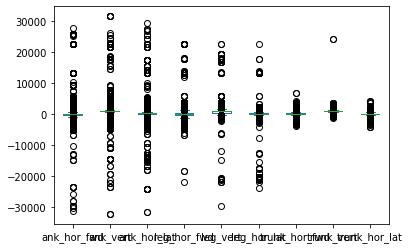

In [13]:
all_df[feature_col_names].plot.box()

In [14]:
for key,old_dfs in dataframes.items():
    new_dfs = []
    for df in old_dfs:
        new_df = remove_outliers(df, feature_col_names)
        new_dfs.append(new_df)
    dataframes[key] = new_dfs

In [15]:
no_outlier_subjects = {}
for key in dataframes.keys():
    no_outlier_subjects [key] = pd.concat(dataframes[key])

In [16]:
all_df_no_outliers = pd.concat(no_outlier_subjects.values())

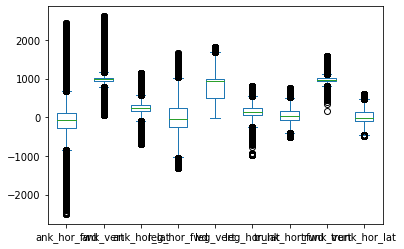

In [17]:
all_df_no_outliers[feature_col_names].plot.box()

## Feature Engineering

Since we are handling time series data (the measurements are taken continiously), past measurements could help us predict the current state. (for example, if in the 10th measurement the patient gets FOG, the previous 3 measurements might be slightly different than every other regular measurement, even thought they are labeled as regular)

Using window of 4 seconds, calculate mean,var,std for every window and add to measurements within the window as new attributes

In [18]:
for key,old_dfs in dataframes.items():
    print(key)
    new_dfs = []
    for df in old_dfs:
        new_df = add_lookback(df, ['time', 'label'], 4)
        new_dfs.append(new_df)
    dataframes[key] = new_dfs

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


2
3
4
5
6
7
8
9
10


In [19]:
no_outlier_subjects = {}
for key in dataframes.keys():
    no_outlier_subjects [key] = pd.concat(dataframes[key])

In [20]:
for key, subject in no_outlier_subjects.items():
    no_outlier_subjects[key].loc[:,'id'] = key

In [21]:
all_df_no_outliers = pd.concat(no_outlier_subjects.values())
all_df_no_outliers.head()

,time,ank_hor_fwd,ank_vert,ank_hor_lat,leg_hor_fwd,leg_vert,leg_hor_lat,trunk_hor_fwd,trunk_vert,trunk_hor_lat,...,leg_hor_fwd_var,trunk_hor_fwd_var,trunk_hor_lat_var,leg_vert_var,ank_hor_fwd_var,trunk_vert_var,leg_hor_lat_var,ank_vert_var,ank_hor_lat_var,id
47999,750000,-30,990,326,-45,972,181,-38,1000,29,...,5140.245941,878.751961,522.836213,204.930821,1235.714078,377.922656,523.229167,232.015625,510.466115,1
48000,750015,-30,1000,356,-18,981,212,-48,1028,29,...,5140.245941,878.751961,522.836213,204.930821,1235.714078,377.922656,523.229167,232.015625,510.466115,1
48001,750031,-20,990,336,18,981,222,-38,1038,9,...,5140.245941,878.751961,522.836213,204.930821,1235.714078,377.922656,523.229167,232.015625,510.466115,1
48002,750046,-20,1000,316,36,990,222,-19,1038,9,...,5140.245941,878.751961,522.836213,204.930821,1235.714078,377.922656,523.229167,232.015625,510.466115,1
48003,750062,0,990,316,36,990,212,-29,1038,29,...,5140.245941,878.751961,522.836213,204.930821,1235.714078,377.922656,523.229167,232.015625,510.466115,1


In [22]:
all_df_no_outliers = all_df_no_outliers.merge(subject_df, on=['id'], how='inner')
all_df_no_outliers = all_df_no_outliers.apply(pd.to_numeric)
print(all_df_no_outliers.info())
all_df_no_outliers.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845598 entries, 0 to 845597
Data columns (total 43 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time                845598 non-null  int64  
 1   ank_hor_fwd         845598 non-null  int64  
 2   ank_vert            845598 non-null  int64  
 3   ank_hor_lat         845598 non-null  int64  
 4   leg_hor_fwd         845598 non-null  int64  
 5   leg_vert            845598 non-null  int64  
 6   leg_hor_lat         845598 non-null  int64  
 7   trunk_hor_fwd       845598 non-null  int64  
 8   trunk_vert          845598 non-null  int64  
 9   trunk_hor_lat       845598 non-null  int64  
 10  label               845598 non-null  int64  
 11  leg_hor_fwd_mean    845598 non-null  float64
 12  trunk_hor_fwd_mean  845598 non-null  float64
 13  trunk_hor_lat_mean  845598 non-null  float64
 14  leg_vert_mean       845598 non-null  float64
 15  ank_hor_fwd_mean    845598 non-nul

,time,ank_hor_fwd,ank_vert,ank_hor_lat,leg_hor_fwd,leg_vert,leg_hor_lat,trunk_hor_fwd,trunk_vert,trunk_hor_lat,...,ank_hor_fwd_var,trunk_vert_var,leg_hor_lat_var,ank_vert_var,ank_hor_lat_var,id,gender,age,disease_duration,HY
0,750000,-30,990,326,-45,972,181,-38,1000,29,...,1235.714078,377.922656,523.229167,232.015625,510.466115,1,1,66,16,3.0
1,750015,-30,1000,356,-18,981,212,-48,1028,29,...,1235.714078,377.922656,523.229167,232.015625,510.466115,1,1,66,16,3.0
2,750031,-20,990,336,18,981,222,-38,1038,9,...,1235.714078,377.922656,523.229167,232.015625,510.466115,1,1,66,16,3.0
3,750046,-20,1000,316,36,990,222,-19,1038,9,...,1235.714078,377.922656,523.229167,232.015625,510.466115,1,1,66,16,3.0
4,750062,0,990,316,36,990,212,-29,1038,29,...,1235.714078,377.922656,523.229167,232.015625,510.466115,1,1,66,16,3.0


In [37]:
all_df_no_outliers.describe()

,time,ank_hor_fwd,ank_vert,ank_hor_lat,leg_hor_fwd,leg_vert,leg_hor_lat,trunk_hor_fwd,trunk_vert,trunk_hor_lat,...,ank_hor_fwd_var,trunk_vert_var,leg_hor_lat_var,ank_vert_var,ank_hor_lat_var,id,gender,age,disease_duration,HY
count,8.455980e+05,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,...,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000,845598.000000
mean,1.270765e+06,-95.531470,980.979670,248.131872,-1.143533,792.371693,158.894967,56.985701,975.422696,25.217556,...,32160.043532,5059.163561,9475.403152,25196.470425,7998.953905,5.393391,0.727651,66.340432,13.566200,2.529871
std,6.045876e+05,308.663169,179.246152,145.127858,495.637246,278.602629,188.029635,175.525251,83.173498,185.712816,...,52888.594765,8514.682157,13018.741052,40907.344876,12124.886005,2.864263,0.445169,4.783262,9.348087,0.539741
min,1.850000e+05,-2505.000000,58.000000,-693.000000,-1300.000000,-9.000000,-969.000000,-504.000000,171.000000,-475.000000,...,-565.000000,0.000000,-969.000000,0.000000,0.000000,1.000000,0.000000,59.000000,2.000000,2.000000
25%,7.943000e+05,-272.000000,931.000000,158.000000,-263.000000,509.000000,50.000000,-67.000000,933.000000,-106.000000,...,98.725490,96.220768,167.252551,98.454350,141.971507,3.000000,0.000000,63.000000,6.000000,2.000000
50%,1.176304e+06,-70.000000,1000.000000,237.000000,-45.000000,935.000000,151.000000,38.000000,980.000000,-9.000000,...,7508.725645,1991.599373,3811.123498,2433.556108,2899.008378,5.000000,1.000000,66.000000,9.000000,2.500000
75%,1.726230e+06,111.000000,1029.000000,326.000000,254.000000,981.000000,252.000000,165.000000,1009.000000,126.000000,...,40203.003701,6264.325736,13769.283315,39443.570369,11628.280092,8.000000,1.000000,68.000000,22.000000,3.000000
max,2.930000e+06,2454.000000,2617.000000,1158.000000,1663.000000,1824.000000,808.000000,766.000000,1580.000000,592.000000,...,362060.732964,113764.500000,116411.776224,316930.334482,175078.002194,10.000000,1.000000,75.000000,30.000000,4.000000


# Train Test Split

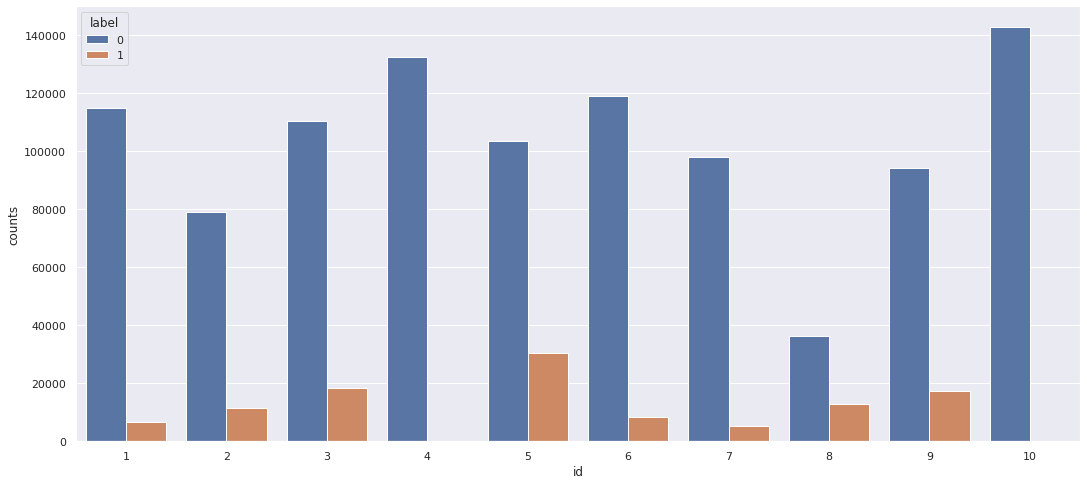

In [23]:
freq_plot1=all_df.filter(items=['id', 'label'])
freq_plot1=freq_plot1.groupby(['id'])['label'].agg(counts='value_counts').reset_index()
sns.set(rc={'figure.figsize':(18,8)})
sns.barplot(data = freq_plot1, x = 'id', y = 'counts', hue = 'label', ci = None)

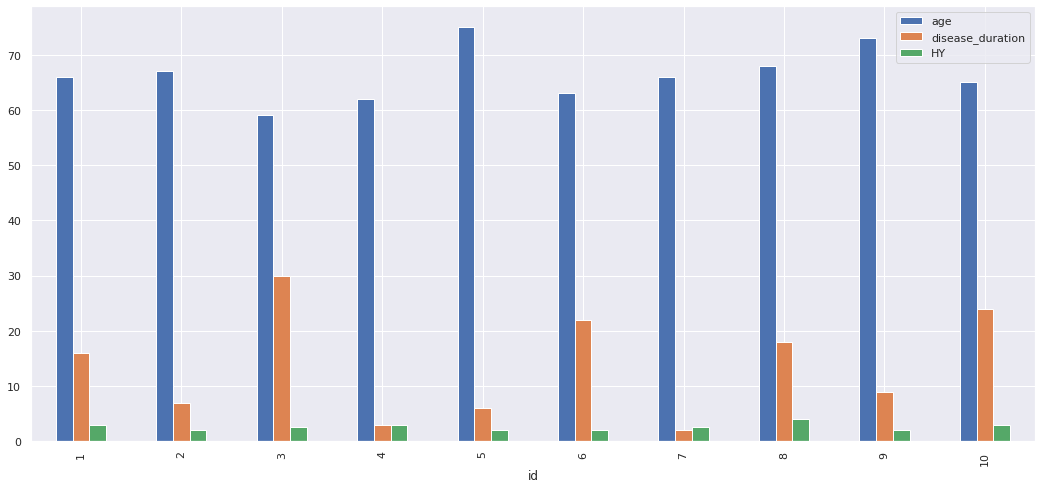

In [24]:
subject_df.plot(x="id", y=["age", 'disease_duration', 'HY'], kind="bar")

I would like to choose a subject to be my test subject. In the study report they concluded that 4 and 10 have the best predictions (but they dont have FOG measurements so thats very biased) Also, The worst results were of subjects 1 and 8. In this case, subject 2 seems pretty average and would be a good choice for vlaidation. At the end, i will need to cross validate my model for each subject in the left one out method (train on 9, test on 1), to ensure that my model is capable of handling all kinds of data.

In [25]:
test_subjs = set([2])
train_subjs = set(subject_df['id']) - test_subjs
print(test_subjs, train_subjs)

{2} {1, 3, 4, 5, 6, 7, 8, 9, 10}


In [26]:
test_df = all_df[all_df['id']==list(test_subjs)[0]]
train_df = all_df[all_df['id'].isin(train_subjs)]

In [27]:
X_train = train_df.drop(['time', 'label','id'], axis=1)
y_train = train_df['label']

X_test = test_df.drop(['time', 'label','id'], axis=1)
y_test = test_df['label']

# Handling Unbalanced Data

We can see below that the data is highly imbalanced.

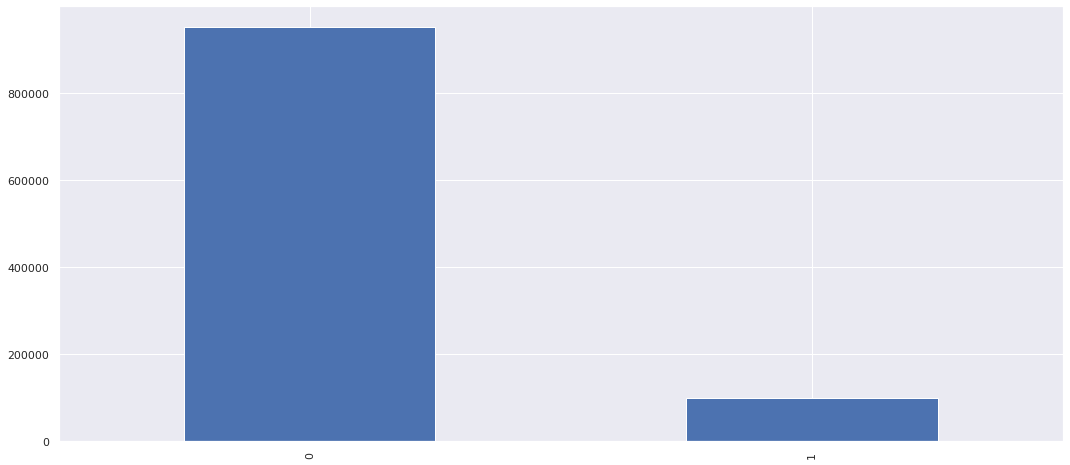

In [28]:
y_train.value_counts().plot.bar()

To solve that, whe can use an oversampling algorithm to balance the dataset.

In [29]:
oversample = imblearn.over_sampling.SMOTE(sampling_strategy='minority')

In [30]:
X_over, y_over = oversample.fit_resample(X_train, y_train)

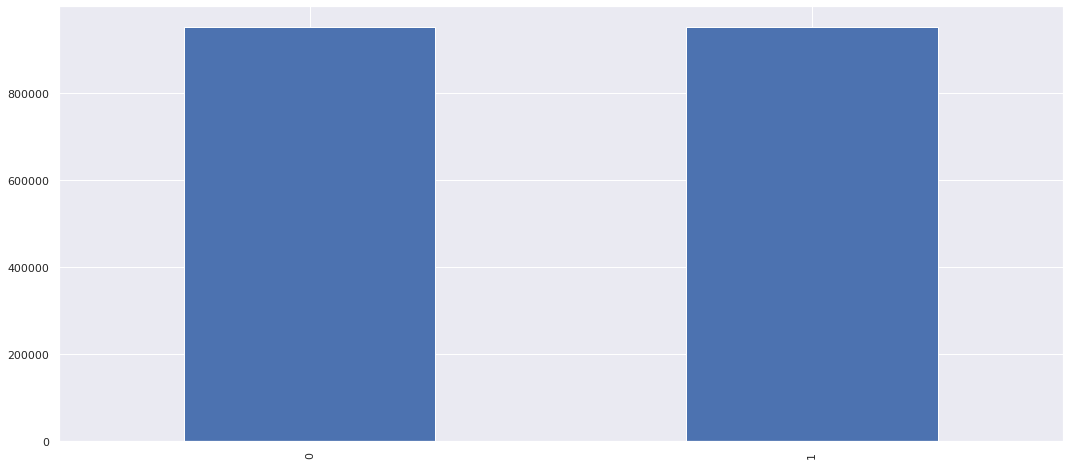

In [31]:
y_over.value_counts().plot.bar()

# Weighted XGBoost Classifier

Since we are mostly interested in recall and percision, we should use f score as our metric. We can define a custom error metric for the model, which will be 1-f_score

Before fitting my Xgboost classifier, ill try to use cross validation to find the optimal weight parameter. Ill try to choose between my default calculated weight and some other variations.

In [32]:
best_weight = find_best_weight(X_over, y_over)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best: 0.820404 using {'scale_pos_weight': 1}


Now, lets fully train our model with the best weight we found using the cross validation.

In [42]:
xg_cls = xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.1,
               n_estimators = 100, nthread=8, scale_pos_weight=best_weight, booster='gbtree', tree_method='gpu_hist', gpu_id=0)
xg_cls.fit(X_over, y_over, eval_metric=f1_eval,eval_set=[(X_over, y_over), (X_test, y_test)],  
           verbose=False, early_stopping_rounds=10)
results = xg_cls.evals_result()

In [43]:
preds = xg_cls.predict(X_test)
print_scores(y_test, preds)

Total accuracy is 0.40501534860095845
Percision score (tp / (tp + fp)) is 0.17412352378896734
Recall score (tp / (tp + fn)) is 0.9728658799207511
F1 score (2 * (precision * recall) / (precision + recall)) is 0.29537994795412637


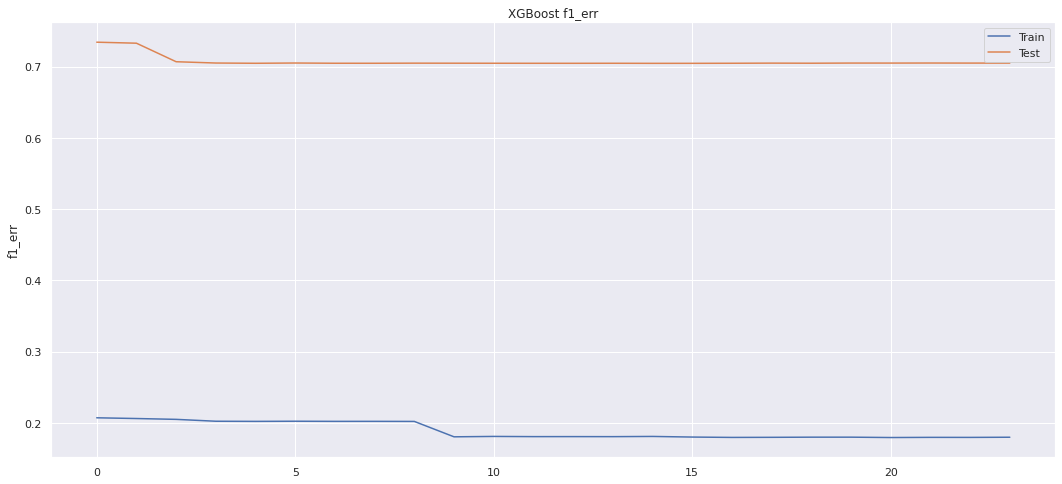

In [44]:
plot_training_chart(results, ['f1_err'], train=True)

True positive samples: 11294 (these are the FOG samples we classified FOG)
False positive samples: 53568 (these are normal samples we classified as FOG)
True negative samples: 25385 (These are the normal samples we classified as normal)
False negative samples: 315 (Thses are the FOG samples we classified as normal)


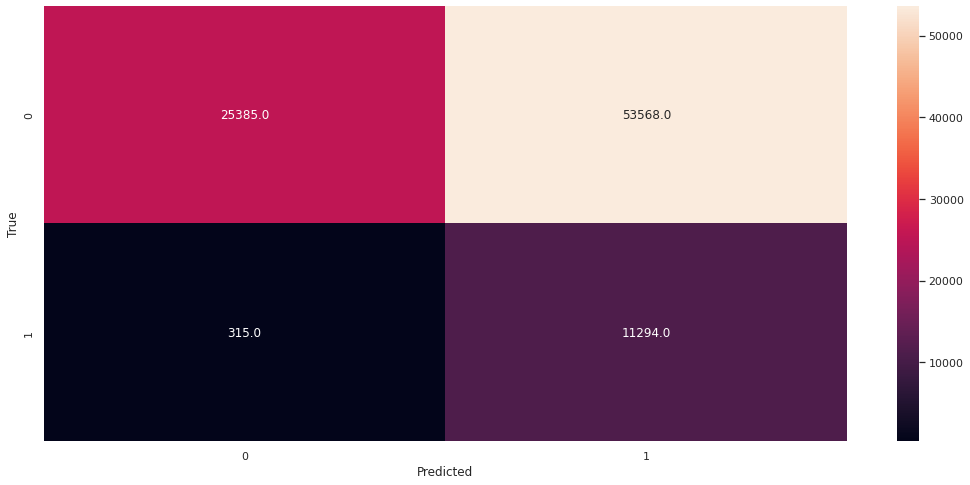

In [45]:
cf_matrix = confusion_matrix(y_test, preds)
draw_confusion_matrix(cf_matrix)

# Weighted XGBoost Classifier + Feature Extraction

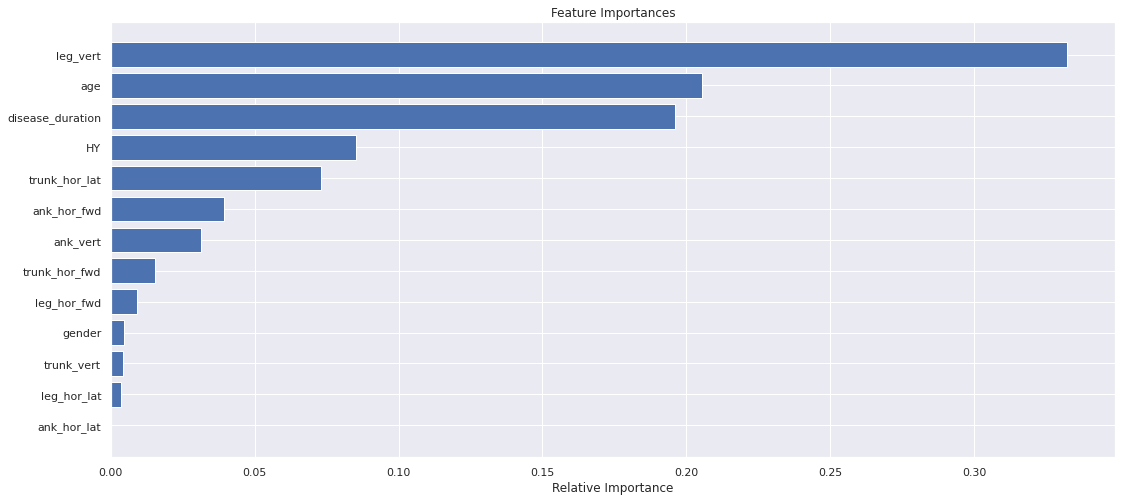

In [46]:
features = list(X_over.columns)
importances = xg_cls.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [47]:
best_20 = [features[i] for i in indices[-20:]]
X_train_ext = X_over[best_20]
X_test_ext = X_test[best_20]

In [48]:
xg_cls = xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.1,
               n_estimators = 100, nthread=8, scale_pos_weight=best_weight, booster='gbtree', tree_method='gpu_hist', gpu_id=0)
xg_cls.fit(X_train_ext, y_over, eval_metric=f1_eval,eval_set=[(X_train_ext, y_over), (X_test_ext, y_test)],  verbose=False, early_stopping_rounds=10)
results = xg_cls.evals_result()

In [51]:
preds = xg_cls.predict(X_test_ext)
print_scores(y_test, preds)

Total accuracy is 0.40501534860095845
Percision score (tp / (tp + fp)) is 0.17412352378896734
Recall score (tp / (tp + fn)) is 0.9728658799207511
F1 score (2 * (precision * recall) / (precision + recall)) is 0.29537994795412637


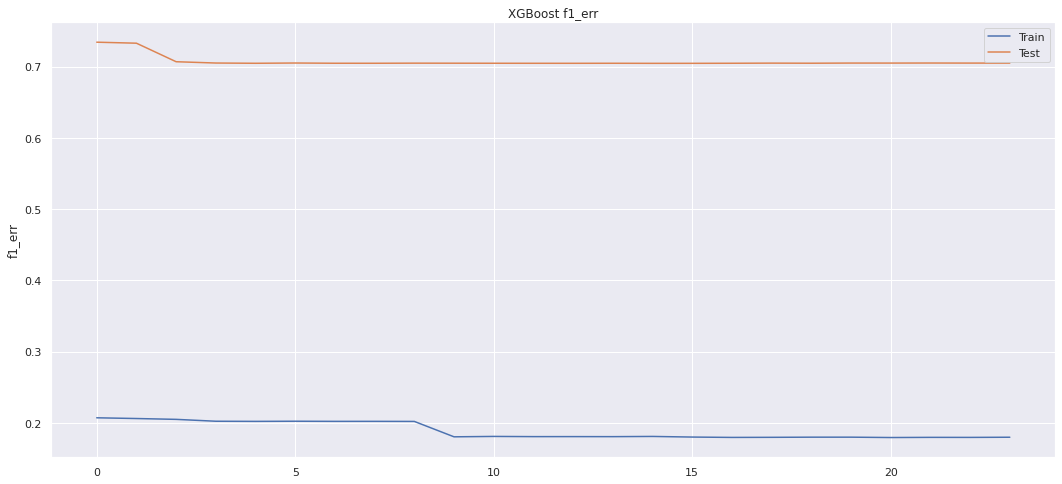

In [52]:
plot_training_chart(results, ['f1_err'], train=True)

True positive samples: 11294 (these are the FOG samples we classified FOG)
False positive samples: 53568 (these are normal samples we classified as FOG)
True negative samples: 25385 (These are the normal samples we classified as normal)
False negative samples: 315 (Thses are the FOG samples we classified as normal)


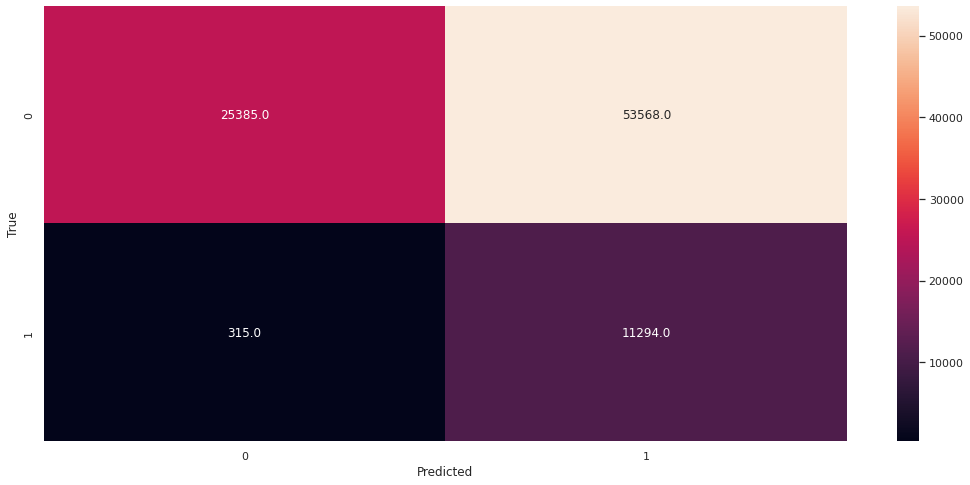

In [53]:
cf_matrix = confusion_matrix(y_test, preds)
draw_confusion_matrix(cf_matrix)

# 'Leave One Out' Cross Validation

In [54]:
np.unique(y_train.values, return_counts=True)

(array([0, 1]), array([951097,  99176]))

In [55]:
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []
for test_subj in set(subject_df['id']):
    train_subjs = set(subject_df['id']) - set([test_subj])
    test_df = all_df_no_outliers[all_df_no_outliers['id']==test_subj]
    train_df = all_df_no_outliers[all_df_no_outliers['id'].isin(train_subjs)]
    
    X_train = train_df.drop(['time', 'label','id'], axis=1)
    y_train = train_df['label']
    y_train -= 1
    
    X_test = test_df.drop(['time', 'label','id'], axis=1)
    y_test = test_df['label']
    y_test -= 1
    
    best_weight = find_best_weight(X_train, y_train)
    
    xg_cls = xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.1,
               n_estimators = 100, nthread=8, scale_pos_weight=best_weight, booster='gbtree', tree_method='gpu_hist', gpu_id=0)
    xg_cls.fit(X_train, y_train, eval_metric=f1_eval,eval_set=[(X_train, y_train), (X_test, y_test)],  verbose=False, early_stopping_rounds=10)
    
    preds = xg_cls.predict(X_test)
    print(f'The results for test subject {test_subj} are:')
    print_scores(y_test, preds)
    f1_scores.append(f1_score(y_test, preds, zero_division=1))
    recall_scores.append(recall_score(y_test, preds, zero_division=1))
    precision_scores.append(precision_score(y_test, preds, zero_division=1))
    accuracy_scores.append(accuracy_score(y_test, preds))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best: 0.583420 using {'scale_pos_weight': 4}
The results for test subject 1 are:
Total accuracy is 0.9258249978626998
Percision score (tp / (tp + fp)) is 0.22462012772517068
Recall score (tp / (tp + fn)) is 0.22972972972972974
F1 score (2 * (precision * recall) / (precision + recall)) is 0.2271461975281149
Fitting 2 folds for each of 7 candidates, totalling 14 fits
Best: 0.597115 using {'scale_pos_weight': 4}
The results for test subject 2 are:
Total accuracy is 0.8246988555795867
Percision score (tp / (tp + fp)) is 0.3774430474293539
Recall score (tp / (tp + fn)) is 0.7305143958559209
F1 score (2 * (precision * recall) / (precision + recall)) is 0.49772232937989913
Fitting 2 folds for each of 7 candidates, totalling 14 fits
Best: 0.587067 using {'scale_pos_weight': 4}
The results for test subject 3 are:
Total accuracy is 0.8509346842857312
Percision score (tp / (tp + fp)) is 0.0
Recall score (tp / (tp + fn)) is 0.0
F1 score (

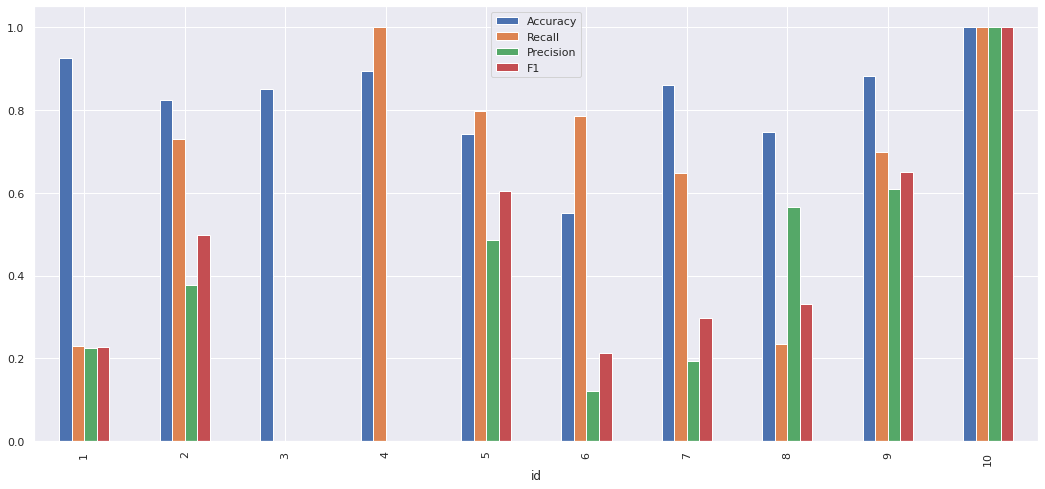

In [56]:
ids = list(range(1,11))
df = pd.DataFrame({'id':ids, 'Accuracy':accuracy_scores, 'Recall':recall_scores, 'Precision':precision_scores, 'F1':f1_scores})

df.plot(x="id", y=["Accuracy", 'Recall', 'Precision', 'F1'], kind="bar")

In [57]:
print(f'The average accuracy was {sum(accuracy_scores)/len(accuracy_scores)}')      
print(f'The average recall was {sum(recall_scores)/len(recall_scores)}')
print(f'The average precision was {sum(precision_scores)/len(precision_scores)}')
print(f'The average f1 score was {sum(f1_scores)/len(f1_scores)}')

The average accuracy was 0.8274780154815655
The average recall was 0.6122101226254841
The average precision was 0.3579039969437914
The average f1 score was 0.3821271014486152
